In [2]:
# Importing libraries
import random
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
from easyimages import EasyImageList,EasyImage
import re
# import pytesseract





random.seed(42)

In [3]:
import cv2


In [ ]:
import easyocr


In [ ]:
import tqdm
import contractions
from unidecode import unidecode
from collections import Counter
from torchtext.data import get_tokenizer
from torchtext.data.utils import ngrams_iterator
from ftlangdetect import detect
from googletrans import Translator

# Data Exploration

### Image Exploration
* Print the count of images
* Print dimension and plot the dimension to identify if any resizing would be required. CNN's require fix input size, so need to explore on the image size.
* Identify if any of the image is corrupted
* Image Color Intensity to identify dark and light images which could come handy later on to tune the model

In [2]:
PROJECT_DIR = os.getcwd()  # get the current working directory
DATA_DIR = os.path.join(PROJECT_DIR, 'data') # Concatenate the folder name which contains images
DATA_DIR  # Check the final path value

'/home/bairathirahul/Workspace/meme-generation/data'

In [3]:
# Point to the memes folder from the data directory
image_dir = os.path.join(DATA_DIR, "memes")
image_files = os.listdir(image_dir)  # get the meme images filenames from the path
print(f'The meme image file names : {image_files}')


# Need to check the images with - 'i-dont-give-a-fuck-sexwithoutpermission.jpg

The meme image file names : ['thumbs-up-steve.jpg', 'bane-permission-to-die.jpg', 'gena-orlov.jpg', 'julia-gillard.jpg', 'a-mi-no-me.jpg', 'irresponsible-nyan-cat.jpg', 'guffdead.jpg', 'friendly-creepy-guy.jpg', 'craig-would-be-so-happy.jpg', 'bigyan-ng-jacket.jpg', 'sarcastic-wonka.jpg', 'very-optimistic-smile.jpg', 'typical-proger.jpg', 'stoner-stanley.jpg', 'people-are-fucking-stupid.jpg', 'anxiety-cat.jpg', 'anti-joke-castiel.jpg', 'chibolo-de-mierda.jpg', 'tony-montana.jpg', 'good-guy-gregs-dog.jpg', 'andr-villas-boas.jpg', 'chan-chan.jpg', 'carl-spackler.jpg', 'chadbrochill.jpg', 'regretting-panda.jpg', 'typical-aussie.jpg', 'tegaki-rp-tuna.jpg', 'bad-billie-joe.jpg', 'the-wtf-mordecai.jpg', 'quirky-turkey.jpg', 'typical-fans-the-x-files.jpg', 'please-guy.jpg', 'bad-luck-drizzy.jpg', 'know-it-all-student.jpg', 'crying-face.jpg', 'oh-kakashi.jpg', 'bill-murray-caddyshack.jpg', 'x-is-bad-and-you-should-feel-bad.jpg', 'terry-tibbs.jpg', 'socially-awesome-awkward-penguin.jpg', 'james

In [4]:
image_list = EasyImageList.from_folder(image_dir)
image_list.html(sample=500, size=50)

In [5]:
# Collect memes file attributes
image_count = 0  # variable to keep the count of number of images
image_broken = 0
image_filetypes = {}
image_widths = []
image_heights = []
image_dimensions = {}
image_aspect_ratio = []
image_modes = {}
image_blank = {}

for image_file in image_files:  # Iterate on every meme image
    try:
        image = PIL.Image.open(os.path.join(image_dir, image_file))

        # image count
        image_count += 1

        # Get the count of different extensions for the image
        image_filetypes[image.format] = image_filetypes.get(image.format, 0) + 1


        # # read image file type
        # template_filetypes[image_file.split(".")[-1]] = (
        #     template_filetypes.get(image_file.split(".")[-1], 0) + 1
        # )

        # retrieve the color mode of each of the image
        image_modes[image.mode] = image_modes.get(image.mode, 0) + 1

        # get the image dimensions
        image_widths.append(image.size[0])
        image_heights.append(image.size[1])

        # get the count of images for each unique dimension
        image_dimensions[image.size] = image_dimensions.get(image.size, 0) + 1

        # determine the aspect ratio of the image
        aspect_ratio = image.size[0] / image.size[1]
        image_aspect_ratio.append(aspect_ratio)

        # determine if image is blank (extrema gives the value of the darkest and lightest pixel)
        # Convert the RGB image to a greyscale and get the extreme pixel values
        extrema = image.convert("L").getextrema()
        # if both the extreme values are same, then the image is just in one color, i.e there is nothing in image (later on we will check what is the caption for the image)
        if extrema[0] == extrema[1]:
            # get the image file and the value of the pixel
            image_blank[image_file] = extrema[0]

        # close the image
        image.close()

    # Exception handling
    except Exception as e:
        print("Could not read image file {}".format(image_file), e)
        image_broken += 1


# Print all the variables
print("Total memes: {}".format(image_count))
print("Broken memes: {}".format(image_broken))
print("Meme file types: {}".format(image_filetypes))
print("Meme modes: {}".format(image_modes))
print("Meme dimensions: {}".format(image_dimensions))
print("Blank memes: {}".format(image_blank))

Total memes: 2504
Broken memes: 0
Meme file types: {'JPEG': 2504}
Meme modes: {'RGB': 2504}
Meme dimensions: {(250, 250): 2461, (225, 225): 5, (150, 150): 1, (232, 232): 1, (227, 227): 2, (200, 200): 3, (224, 224): 2, (199, 199): 1, (248, 248): 1, (240, 240): 2, (210, 210): 1, (170, 170): 1, (183, 183): 1, (213, 213): 1, (180, 180): 1, (226, 226): 1, (135, 135): 1, (245, 245): 1, (230, 230): 2, (195, 195): 1, (208, 208): 1, (220, 220): 2, (216, 216): 2, (211, 211): 1, (194, 194): 1, (128, 128): 1, (174, 174): 1, (233, 233): 1, (197, 197): 1, (157, 157): 1, (360, 356): 1, (222, 222): 1}
Blank memes: {'blank-template.jpg': 255, 'blank-black.jpg': 0}


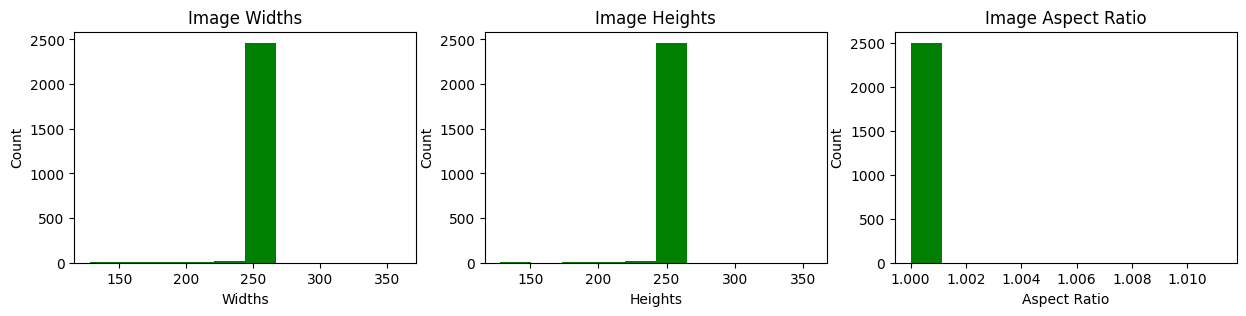

In [6]:
# Get the distribution on the different widths, heights and the aspect ratio of the images
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].hist(image_widths, bins=10,color='green')
ax[0].set_title('Image Widths')
ax[0].set_xlabel('Widths')
ax[0].set_ylabel('Count')

ax[1].hist(image_heights, bins=10,color='green')
ax[1].set_title('Image Heights')
ax[1].set_xlabel('Heights')
ax[1].set_ylabel('Count')

ax[2].hist(image_aspect_ratio, bins=10,color='green')
ax[2].set_title('Image Aspect Ratio')
ax[2].set_xlabel('Aspect Ratio')
ax[2].set_ylabel('Count')

plt.show()

We can see from the plots that the dimensions of most of the images are 250 * 250 and only very few are of dimensions lower than 250. From the meme dimensions variable printed in the previous cell of plot, different dimensions values can be seen and the image count respective to the dimension.
From the aspect ratio it can be seen that we have the square images.
These steps are performed in order to identify the images that would require resizing (images with dimensions other than 250 * 250 ?) - May be easier to downsize image to retain clarity rather than upsizing (Note to exlore)

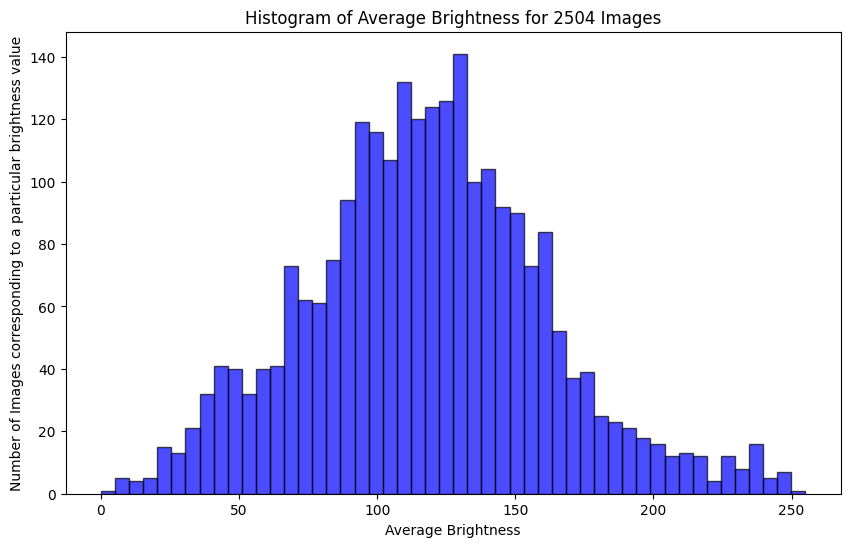

In [7]:
brightness_values = []
darker_image_names = []
lighter_image_names = []

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)

    # Load the image in greyscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Calculate average brightness
    avg_brightness = image.mean()

    # Check if average brightness is less than 50, append the image name to the darker_image_names list
    if avg_brightness < 30:
        darker_image_names.append(image_file)
    elif avg_brightness > 240:
        lighter_image_names.append(image_file)

    # For every image, append the average brightness to the list
    brightness_values.append(avg_brightness)

# Plot histogram of brightness values
plt.figure(figsize=(10, 6))
plt.hist(brightness_values, bins=50, color='blue', alpha=0.7,edgecolor='black')
plt.title(f'Histogram of Average Brightness for {len(brightness_values)} Images')
plt.xlabel('Average Brightness')
plt.ylabel('Number of Images corresponding to a particular brightness value')

# plt.grid(True)
plt.show()

We can see there are some darker images with average brightness on the lower values and some lighter images on the high end values. Brightness can affect feature interpretatino if images. May be beneficial to increase image brigtness to avarage image brightness to help in feature detection/interpretation (note to explore)

In [8]:
images_list = []
for dark_img in darker_image_names:
    image_path = os.path.join(image_dir, dark_img)
    images_list.append(EasyImage.from_file(image_path))

EasyImageList(images_list).html()


In [9]:
images_list = []
for light_img in lighter_image_names:
    image_path = os.path.join(image_dir, light_img)
    images_list.append(EasyImage.from_file(image_path))

EasyImageList(images_list).html()

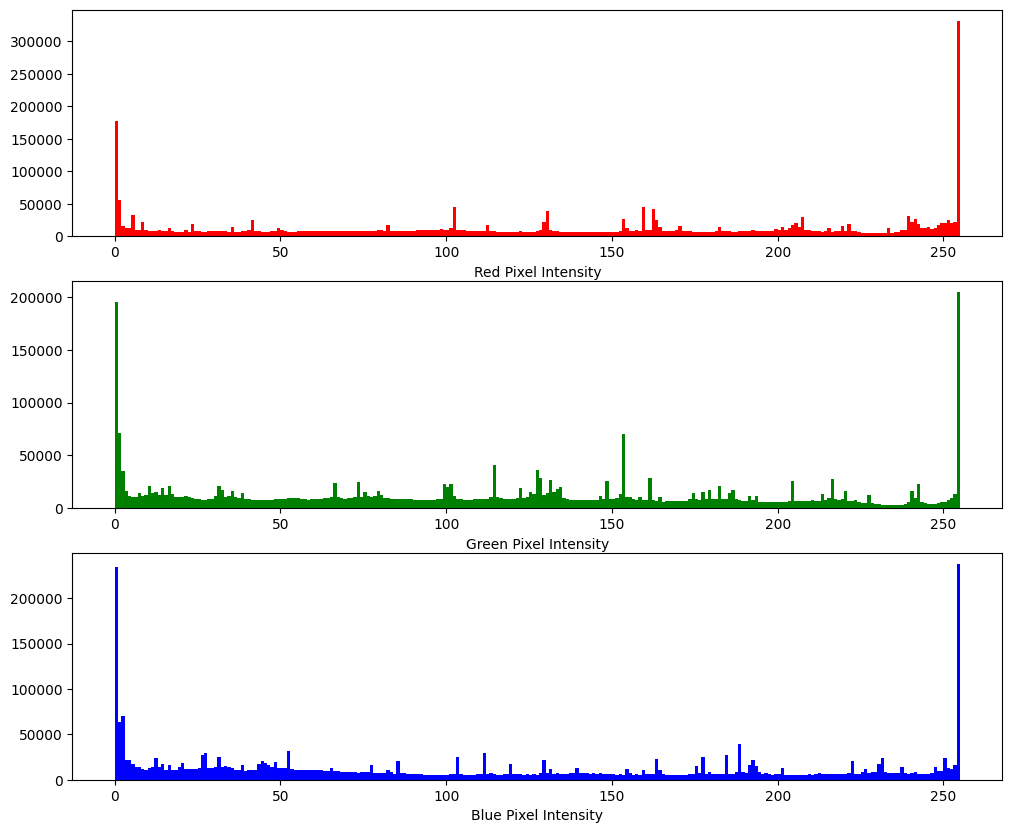

In [10]:
# Image color distribution
colors = {"R": [], "G": [], "B": []}

# For the 50 random images, plot the color distribution
for image_file in random.sample(image_files, 50):
    image = PIL.Image.open(os.path.join(image_dir, image_file))

    image_array = np.array(image)

    colors["R"].extend(image_array[:, :, 0].flatten())
    colors["G"].extend(image_array[:, :, 1].flatten())
    colors["B"].extend(image_array[:, :, 2].flatten())

    image.close()

# Plot color distribution
fig, ax = plt.subplots(3, 1, figsize=(12, 10))
ax[0].hist(colors["R"], bins=255, color = 'red')
ax[0].set_xlabel("Red Pixel Intensity")

ax[1].hist(colors["G"], bins=255, color = 'green')
ax[1].set_xlabel("Green Pixel Intensity")

ax[2].hist(colors["B"], bins=255, color = 'blue')
ax[2].set_xlabel("Blue Pixel Intensity")

plt.show()

In [11]:
# get pytorch device
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060 3GB'

In [12]:
def extract_text_easyocr(image_path,reader_instance):

    # Use the reader to read text from the image
    results = reader_instance.readtext(image_path)

    # Extract and return the text
    extracted_text = "\n".join([result[1] for result in results])
    if len(extracted_text.strip()) > 0:
        return extracted_text

# dictionary to hold the name of the image and the length of text in it
image_with_text = {}

# Create a reader instance
# The line reader = easyocr.Reader(['en']) is for loading a model into memory. It takes some time but it needs to be run only once.(https://github.com/JaidedAI/EasyOCR/tree/master)
print('Model is starting to get load into the memory')
reader = easyocr.Reader(lang_list=['en'], gpu=True, verbose=True)
print('Model loaded into the memory')

for image_file in tqdm.tqdm(image_files):
    image_path = os.path.join(image_dir, image_file) 

    text_retrieved = extract_text_easyocr(image_path,reader)

    if text_retrieved is not None:
        image_with_text[image_file] = text_retrieved  


Model is starting to get load into the memory
Model loaded into the memory


100%|██████████| 2504/2504 [00:53<00:00, 46.53it/s]


In [13]:
image_with_text

{'craig-would-be-so-happy.jpg': 'Cowsi',
 'chibolo-de-mierda.jpg': 'DOSutadsOt\nEhieena\numorcnnMatoi',
 'ancient-alien-guy.jpg': 'H\nTtan n',
 'httpvkcomtatarin-typical.jpg': '5\nVII,CONE',
 'southpark-bad-time-meme.jpg': 'INSTRUCTOR',
 'trsreu.jpg': 'Jaut',
 'brian-scalabrine-white-mamba.jpg': 'CS',
 'typical-mephist.jpg': 'MEPH',
 'el-valor-de-la-verdura-es-verdad.jpg': 'JR',
 'douchebag-college-freshman.jpg': 'TE',
 'vargaistvan.jpg': 'Istvan\nPpt6 Fd1\nVarga !',
 'youre-going-to-have-a-bad-time.jpg': 'INSTRUCTOR',
 'old-success-kid.jpg': 'BxlReay',
 'livy.jpg': 'He;',
 'history-major-heraldic-beast.jpg': 'Ktt\nnlicw\nCom',
 'science-cat.jpg': 'U(ch"',
 'stoned-birthday-dog.jpg': 'DUNNO, MAN\nFMPRETTY HGH',
 'karma-cramer.jpg': 'Move Your Karma Now\nIchm 6.I1\nPictnt\n(BoDB) 9.21 Mockina Peos',
 'angry-cenk.jpg': 'IVh',
 'emocorese.jpg': 'EMocore_sE',
 'kiko-.jpg': 'YA QUE\nCHUCHA',
 'thats-a-paddlin.jpg': "MOTIVATION\npaddlin'",
 'so-hardcore-guy.jpg': 'SO\nHARDCORE',
 'true-life.

In [14]:
# Get the image name from the dictionary
image_with_text_list = [k for k, v in image_with_text.items()]

images_list = []
for img in image_with_text_list:
    image_path = os.path.join(image_dir, img)
    images_list.append(EasyImage.from_file(image_path,label=[img]))

EasyImageList(images_list).html(by_class=False)

# Note:- The Images have been identified which has text in them. These images are not removed right now, we will train the model
# and if the model output is not good, then we will remove the text from the images or we can remove the imges which just has text in it.

# Captions Text Exploration

In [15]:
# Read the captions file
captions = open(os.path.join(DATA_DIR, "captions.txt"), "r").read()

meme_names = {} # dictionary to store image filename and the meme name
meme_captions = {} # dictionary to store the image filename and the meme captions

previous_captions_img_filename = None

# Collect memes and their associated captions
for line in captions.split("\n"):
    # if the line does not contain a dash, it is a continuation of the previous caption
    if line.find('-') == -1 and previous_captions_img_filename is not None:
        meme_captions[previous_captions_img_filename][-1] += " " + line.strip()
        continue

    # Find the index of the dash which separates the image name and the caption
    split_index = line.index(' - ')
    name, caption = line[0:split_index].strip(), line[split_index + 3:].strip()

    # Ignore the empty meme caption
    if not caption:
        continue

    # generate meme image file name - remove special characters and convert to lowercase.
    # It would be an appropriate way to compare for which images captions are available, as
    # there are lot of discrepancies in the names format in image and captions file.
    captions_img_file_name = re.sub(r"[^a-zA-Z0-9]+", '', name.lower()) + ".jpg"

    # The meme_names is prepared to create the image file name so that it can be compared to which image the captions belong to
    meme_names[captions_img_file_name] = name

    # Add all the captions associated with the particular image
    meme_captions[captions_img_file_name] = meme_captions.get(captions_img_file_name, []) + [caption]

    previous_captions_img_filename = captions_img_file_name  # Add the processed image name

# Check randomly for five items added to meme_captions
random.sample(sorted(meme_captions.items()), 5)

[('lolcat.jpg',
  ["Samanta baby i'm ready for you, my love",
   'reow',
   'I tRies To sleep',
   'I can HAz Sleepovers',
   'u can haz cuddlez',
   'Jesus sid: I saw you while you were stll under the fig tree Nathaniel: What!? You Stalker!',
   "PLACEHOLDER FOR FUTURE SECTION THAT WE'RE WORKING VERY HARD ON.",
   'My Owner  IS AN IDIOT',
   'Yes hunter... even lolcats',
   "DON'T F** WITH MY ASHTRAY!",
   'NO U LAUGH AT MY ASHTRAY!',
   'NO U LAUGH AT MY ASHTRAY!',
   'NO U LAUGh At mY ASHTRAY!',
   'NO U LAUGH AT MY ASHTRAY!',
   "Tony abbott Doesn't Understand THe Internet This is what you use it for",
   'Life Hard party harder',
   'no new one until i get a proper reply',
   'http://bit.ly/KaNBOk',
   "I can't haz access to ur outlooks I checks the sharepoint and PTo doesn't ekzist.",
   "I haz question but i don't want to leave my seat.",
   "I haz question but i don't want to leave my seatz",
   'I is in your test code Editing your test code',
   'I made you a nutella cake but 

In [16]:
# Remove the hypens from the images filename to make it consistent with the filename created from captions names
image_filenames_without_dash = set(map(lambda x: x.replace('-', ''), image_files))

# Find the images for which there is no associated captions
no_captions = set(image_filenames_without_dash) - set(meme_captions.keys())
print(f'The total number of images for which no captions were found are :{len(no_captions)}')
no_captions

# Need to remove the images for which the captions were not found from consideration in training samples

The total number of images for which no captions were found are :32


{'TutorPP.jpg',
 'allefobommoo.jpg',
 'andrvillasboas.jpg',
 'carois1.jpg',
 'codaxanacasadossegredos3.jpg',
 'duvetattdursvensknr.jpg',
 'funes20aos.jpg',
 'kibrndultrtelmisgi.jpg',
 'lunaloonylovegood.jpg',
 'miit.jpg',
 'mindenkinyugodjonleapicsba.jpg',
 'msugeofuck.jpg',
 'niomalvadoeviltoddler.jpg',
 'nobastaserpobre.jpg',
 'okay.jpg',
 'oseaquepedo.jpg',
 'oseaqupedomem.jpg',
 'quhorror.jpg',
 'quiendiceenchufetv.jpg',
 'sbpgti.jpg',
 'stavropoltypical.jpg',
 'taemin.jpg',
 'tiffanybitchplease.jpg',
 'tipicalgornyak.jpg',
 'tpicaabuela.jpg',
 'typicallub.jpg',
 'typicalshatura.jpg',
 'unclesi.jpg',
 'uysipeapia.jpg',
 'vitakrnktamannen.jpg',
 'vrn.jpg',
 'yaqupondrasituvierauno.jpg'}

In [17]:
# identify the index of the image file in set
list(image_filenames_without_dash).index('whynotluna.jpg')

887

In [18]:
# Find out the captions for which there is no image available
no_image = set(meme_captions.keys()) - set(image_filenames_without_dash)
print(f'No. of captions for which no image file is available : {len(no_image)}')
no_image

# Note : The .jpg is coming because we have converted the name of the captions to .jpg format to match with image name
# That is how the dataset has been prepared.

No. of captions for which no image file is available : 3


{'duckdynasty.jpg', 'releasethekraken.jpg', 'snsd.jpg'}

In [19]:
# Remove the captions for which the image was not found
for filename in no_image:
    meme_captions.pop(filename)
    meme_names.pop(filename)

In [20]:
# Remove the image and it's associated captions for the completely dark and light image
meme_captions.pop('blankblack.jpg')  #black image
meme_names.pop('blankblack.jpg')

meme_captions.pop('blanktemplate.jpg') #white image
meme_names.pop('blanktemplate.jpg')

'Blank Template'

Text Pre-processing

* Remove multiple spaces
* Convert text to lowercase
* Convert non-english to english
* Convert contractions
*

In [21]:
# An example block
# caption = "Hello, this is some non-ASCII text: Café and Pokémon."
# caption = '¿Qué te gusta hacer?'
caption = 'No hablo español'
ascii_caption = unidecode(caption)

print(ascii_caption)

No hablo espanol


In [22]:
def preprocess_captions(caption):
    """
    Preprocess the captions of the memes
    """

    # Remove multiple spaces and multiple punctuation marks
    caption = re.sub(r"\s+", " ", caption)
    # Replace same punctuation marks ocuuring multiple times with a single instance
    caption = re.sub(r"([.?!])\1+", r"\1", caption)

    # # Remove non-ascii characters
    # caption = "".join(i for i in caption if ord(i) < 128)

    # Change the non-ascii characters to ascii characters
    caption = unidecode(caption)

    # Remove URLs
    caption = re.sub(r"http\S+", "", caption)

    # Expand contractions
    caption = contractions.fix(caption)

    # Split the words joined with hypen or forward slash
    # Eg - "a self-initiated-process" will be converted to - "a self initiated process"
    # caption = re.sub(r"([a-zA-Z0-9])[-\/]([a-zA-Z0-9])", r"\1 \2", caption)
    caption = re.sub(r'(?<=\w)[-\/](?=\w)', ' ', caption)

    # Remove multiple spaces and multiple punctuation marks
    caption = re.sub(r"\s+", " ", caption)

    return caption.lower()

# Check some of the examples
print(preprocess_captions('Sono economicamente messi peggio di noi italiani riescono a permettersi una rete migliore della nostra, tanto da definirsi "Iper-connessionati"'))
print(preprocess_captions('I told him we\'re sending the national un-watering team!'))
print(preprocess_captions('I told-him-we-are - a/team!'))

sono economicamente messi peggio di noi italiani riescono a permettersi una rete migliore della nostra, tanto da definirsi "iper connessionati"
i told him we are sending the national un watering team!
i told him we are - a team!


In [23]:
# Remove duplicate captions from the array
for filename, captions in meme_captions.items():
    # Pre-process captions
    captions = list(map(preprocess_captions, captions))

    # Remove duplicate captions
    original_length = len(captions)

    # get the count of each caption
    counter = Counter(captions)

    # get the captions which are duplicate
    duplicates = [item for item, count in counter.items() if count > 1]

    # remove the duplicate captions
    meme_captions[filename] = list(set(captions))

    new_length = len(meme_captions[filename])

    if original_length != new_length:
        print("Removed {} duplicate captions from {}".format(
            original_length - new_length, filename
        ))
        # print the duplicate captions
        print("Duplicate captions: {}".format(duplicates))

Removed 11 duplicate captions from yuno.jpg
Duplicate captions: ['facebook y you no have dislike button', 'memegenerator go fuck yourself', 'y you no answer', 'born of osiris y you no come to canada?', '\\\\lwvs y you no print?', 'founders y you no have hot water?', 'like bms? y you no', 'y you no like bms', '9gag y you no let me upload more than 2 pics a day', 'y you no pee in your box', 'yu no let us play with phones in tutur?']
Removed 4 duplicate captions from themostinterestingmanintheworld.jpg
Duplicate captions: ['i do not always generate a meme but when i do, i generate them twice', 'i do not always contradict myself but when i do, i do not', 'i do not always finish my sentences but when i do', 'i do not always have alzheimers i do not always have alzheimers']
Removed 2 duplicate captions from futuramafry.jpg
Duplicate captions: ['not sure if wrong password or wrong username', 'not sure if you are busy or just ignoring me']
Removed 1 duplicate captions from successkid.jpg
Dupli

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Using unique captions to capture the most popular words
combined_text = " ".join(str(text) if isinstance(text, str) else " ".join(text) for text in meme_captions.values()) #Combinginall of the captions into one long string

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(combined_text) #Generating wordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


From this Word Cloud we can see the most commonly occuring words within our meme captions. From this word cloud we can see tha a good amount of captions contain some angle of profanity, which will need to be replaced. We will likely replace the profanity with a series of specific characters. This Word Cloud contians Stop Words

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords') #Downloading the stopwords dataset

# split it into words
words = combined_text.split()

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from the sentence
filtered_sentence = [word for word in words if word.lower() not in stop_words]

# Join the filtered words back into a sentence
filtered_sentence = ' '.join(filtered_sentence)

wordcloud_noStop = WordCloud(width=800, height=400, background_color="white").generate(filtered_sentence) #Generating wordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_noStop, interpolation="bilinear")
plt.axis("off")
plt.show()

In [24]:
meme_captions['snoopdogg.jpg']

['someday i will learn how to speak english?',
 'child please do my dishes',
 'snoop lion approves of this name change',
 "why does snoop dogg put oil in his frying pan? fo' sizzle!",
 'fo shizzle donepezil',
 'data dogg',
 'a noir at 12:30? fo shizzle ma nizzle',
 'with so much drama in the lbc its kind of hard being midlandco it',
 'hola debi soy la anto',
 'smile erky fo shizzle',
 'la di da di i gots ta potty',
 'hickory dickory dock this bitch was suckin my cock the clock struck two i blew my goo and dumped her at the end of the block.',
 'open wizzle the skizzle',
 'joint tenant',
 'i believe i was bob marley in a past life even though i was born before he died!',
 'that awkward moment when snoop dogg is living "young wild and free" even though he is 41',
 'i do not always rap but when i do i spell out everything',
 'po bizzle in the hizzle',
 "hillary is going to prizzle fo' shizzle",
 'is asked how the gorillaz colab happened basically says they made music in the studio',
 'if 

In [25]:
# Generate vocabulary in this state
tokenizer = get_tokenizer("basic_english")
vocab = []
for filename, captions in meme_captions.items():
    for caption in captions:
        # Add all the tokens created by (tokenizer(caption)) to the vocab list (extend adds multiple elements to the list)
        vocab.extend(tokenizer(caption))

print("Vocabulary size: {}".format(len(set(vocab))))

Vocabulary size: 148206


For count 1 ['nananananananananananananananananananananananananananananana', '#takesyouforevertoread', '01001100011001010111010001110011001000000110011101100101011101000010000001101001011101000010000001101111011011100010000001110100011011110110111001101001011001110110100001110100', 'nieeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee', '______________________', 'analytics@socialbrothers', 'eeeeeeeeeaaaaaaaaaaaaaaaasyyyyyyyyyy', 'wubwubwubwawawaawobwobwob', 'arrrrrrrghhhhhhhhhhhhh', 'cooooooookiessssssssssss', 'fffffuuuuuuuuuuuuuuuuuuuuuuuuuu', 'fffffffffffuuuuuuuuuuuuu', 'ffffffffffuuuuuuuuuuuuuuuuuu', 'fffffffffuuuuuuuuuuuu-', 'hellllllllllllllpppppppppp', 'mmmmwwwaaaahhhaaahhhaaa', 'aaaaaaaaaaaannnnndddd', 'neishxjqoaopqkencnwiannwkanchwkanxkflwlxjrbwkansndnfkelnznw', 'gahwahfebenlebenargle', 'uuuuuuuuuuuuuuuugggggggggggggggg', 'jusssssssssssssssstin', 'spaces_are_so_main_stream', 'asijfghiuayewfiaviuaytvjfevk', '23579888988588783701132217644322286884', 

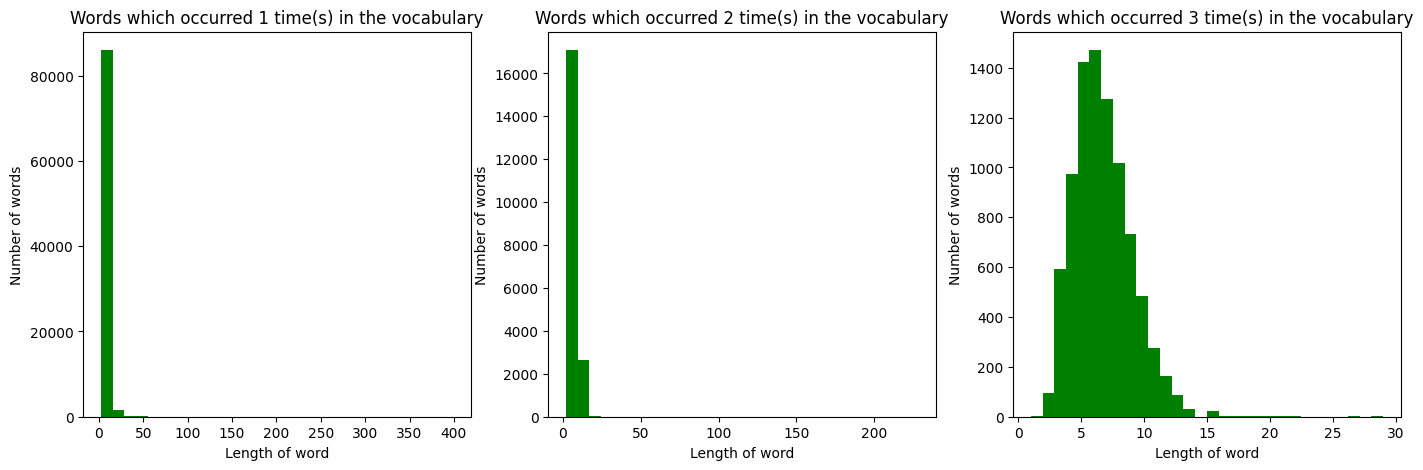

In [26]:
# Count the occurrence of words in vocabulary
wordcount = Counter(vocab)
# Plot the length of words which has the count of 1,2,3

# Create a subplot for each count
fig,ax = plt.subplots(1, 3, figsize=(17, 5))

for i in range(1,4):
    # Get the words which has the count equal to i
    words = [word for word, count in wordcount.items() if count == i]

    # Print the word which is of length > 20
    print(f'For count {i}',[word for word in words if len(word) > 20])   

    # Plot the histogram
    ax[i-1].hist([len(word) for word in words], bins=30,color='green')
    ax[i-1].set_title(f'Words which occurred {i} time(s) in the vocabulary')
    ax[i-1].set_xlabel("Length of word")
    ax[i-1].set_ylabel("Number of words")

# Note:- We can see the presence of words which would not make sense even for meme generation

In [27]:
# Get the words which have occurred only once and twice and the length of the word is greater than 25
least_common_words = [word for word, count in wordcount.items() if count >= 2 and len(word) > 20]
least_common_words

['mayoupleasrepethaword',
 'fuuuuuuuuuuuuuuuuuuuuuuuuuuuuu',
 'ssssssssssssssssssssss',
 'ahahahahahahahahahaha',
 'nooooooooooooooooooooo',
 'nooooooooooooooooooooooooo',
 'noooooooooooooooooooo',
 'scienceofrelationships',
 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx',
 'hahahahahahahahahahaha',
 'ooooooooooooooooooooooooooo',
 'hugssssssssssssssssss',
 'creaturessssssssssssss',
 '---------------------',
 'bestgurlfriendsforlife',
 'nyannyannyannyannyannyan',
 'professionalrecreationalist@yahoo',
 'hahahahahahahahahahahaha',
 '1415926535897932384626433832795028841971693993751058209',
 '7494459230781640628620899862803482534211706798214808651',
 'grrrrrrrrrrrrraaaaiiiii',
 'trolololololololololololololololololololololololololololololololololololololololololololololololololololololololo',
 'trololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololo

In [28]:
# Replace the least common words with <unk>

for filename, captions in meme_captions.items():
    for i, caption in enumerate(captions):
        captions[i] = " ".join(
            [
                "<unk>" if word in least_common_words else word
                for word in tokenizer(caption)
            ]
        )

In [29]:
# Remove all captions with just <unk>, less than 3 tokens and just punctuations

def is_valid_caption(caption):
    """
    Check if the caption is valid
    """
    
    tokens = tokenizer(caption)

    if len(tokens) < 3:  # Check if only 2 tokens are present
        return False

    if set(tokens) == {"<unk>"}: # Check if all the tokens are <unk>
        return False

    # Check if the tokens are alphanumeric
    alphanumeric_tokens = list(filter(lambda x: x.isalnum(), tokens))

    # If there are no alphanumeric tokens, then return false 
    if set(alphanumeric_tokens) == '':
        return False
    
    return True   
  

for filename, captions in meme_captions.items():
    # Collect the list of captions which were not valid, i.e would be removed
    invalid_captions = list(filter(lambda x: not is_valid_caption(x), captions))

    # Retrieve the valid captions (filter function is applied to each element of the iterable)
    captions = list(filter(is_valid_caption, captions))

    if invalid_captions:
        print("Removed {} captions from {}".format(len(invalid_captions), filename))
        print("Removed captions are: {}".format(invalid_captions))

    meme_captions[filename] = captions

Removed 4 captions from yuno.jpg
Removed captions are: ['no', 'sik kafa', 'k', 'abe']
Removed 1 captions from badluckbrian.jpg
Removed captions are: ['yolo reincarnated']
Removed 1 captions from foreveralone.jpg
Removed captions are: ['username available']
Removed 1 captions from goodguygreg.jpg
Removed captions are: ['upvote anyway']
Removed 1 captions from scumbagsteve.jpg
Removed captions are: ['supports sopa']
Removed 1 captions from kermitthefrogdrinkingtea.jpg
Removed captions are: ['hey']
Removed 1 captions from allthethings.jpg
Removed captions are: ['boobies']
Removed 1 captions from josephducreux.jpg
Removed captions are: ['wench please']
Removed 2 captions from pedobear.jpg
Removed captions are: ['bearly legal', 'explored dora']
Removed 3 captions from trollface.jpg
Removed captions are: ['error 37', 'ctrl w', 'press f13']
Removed 1 captions from skeptical3rdworldkid.jpg
Removed captions are: ['what thot']
Removed 1 captions from disastergirl.jpg
Removed captions are: ['poke

In [30]:
def is_english_text(caption):
    """
    Preprocess the captions of the memes
    """

    tokens = tokenizer(caption)

    languages = [detect(text=ngram)["lang"] for ngram in ngrams_iterator(tokens, 3)]

    is_english = (
        len([lang for lang in languages if lang == "en"]) / len(languages)
    ) > 0.3

    return is_english

non_english_captions = []
# Translate captions to english
for filename, captions in tqdm.tqdm(meme_captions.items()):
    for i, caption in enumerate(captions):
        if not is_english_text(caption):
            non_english_captions.append(caption)

print(len(non_english_captions))
random.sample(non_english_captions, 10)

100%|██████████| 2454/2454 [00:36<00:00, 68.00it/s] 

28422


['uncel dolan iz wutching you',
 'greator demons ? baneblade torso !',
 'ase mas kouklitsa mou',
 'yo aki y ud k hace',
 'piercings , tattoos , alargadores sou uma pessoa completamente diferente',
 'arf arf arf',
 'aresenal menang apa gak sih ? coba tanya henry',
 'damiano wieder mit . meike ?',
 'cual llama ? ola k ase',
 'su nivel de estupidez es muy alto']

In [31]:
# Checkpoint, save the preprocessed captions file
np.save(os.path.join(PROJECT_DIR, "non_english_captions.npy"), non_english_captions)

In [ ]:
# Translating the non-english text separately because this call might fail

translator = Translator()

translated_captions = {}
i = 0
while i < len(non_english_captions):
    try:
        print(i)
        caption = non_english_captions[i]
        translated_captions[caption] = translator.translate(caption).text
        i += 1
    except:
        time.sleep(30)

random.sample(list(translated_captions.items()), 10)